In [1]:
import sympy as sym
import numpy as np
import scipy as sp
from scipy import linalg,spatial,signal

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
# PALIČJE

# masna matrika
def M_p(A, L, ρ):

    M = ρ*A*L/6*np.array([
    [2, 0, 1, 0],
    [0, 2, 0, 1],
    [1, 0, 2, 0],
    [0, 1, 0, 2]])
    
    return M

def K_p(A, E, L, α):

    c = np.cos(α)
    s = np.sin(α)
    
    K = A*E/L*np.array([
    [ c**2,   s*c, -c**2,  -s*c],
    [  s*c,  s**2,  -s*c, -s**2],
    [-c**2,  -s*c,  c**2,   s*c],
    [ -c*s, -s**2,   s*c,  s**2]])
    
    return K

In [3]:
# OKVIR
# transformacijska matrika
def T(α):
    
    T = np.array([[ np.cos(α), np.sin(α), 0,         0,         0, 0],
                   [-np.sin(α), np.cos(α), 0,         0,         0, 0],
                   [         0,         0, 1,         0,         0, 0],
                   [         0,         0, 0, np.cos(α), np.sin(α), 0],
                   [         0,         0, 0,-np.sin(α), np.cos(α), 0],
                   [         0,         0, 0,         0,         0, 1]])
        
    return T

# masna matrika
def M_o(A, L, ρ, α):

    M_lok = ρ*A*L*np.array([[1/3,         0,         0, 1/6,         0,         0],
                            [  0,     13/35,  11*L/210,   0,      9/70, -13*L/420],
                            [  0,  11*L/210,  L**2/105,   0,  13*L/420, -L**2/140],
                            [1/6,         0,         0, 1/3,         0,         0],
                            [  0,      9/70,  13*L/420,   0,     13/35, -11*L/210],
                            [  0, -13*L/420, -L**2/140,   0, -11*L/210,  L**2/105]])
    
    return T(α).T @ M_lok @ T(α)

# togostna matrika
def K_o(A, E, I, L, α):

    K_lok = E/L*np.array([[ A,          0,      0, -A,          0,      0],
                          [ 0,  12*I/L**2,  6*I/L,  0, -12*I/L**2,  6*I/L],
                          [ 0,      6*I/L,    4*I,  0,     -6*I/L,    2*I],
                          [-A,          0,      0,  A,          0,      0],
                          [ 0, -12*I/L**2, -6*I/L,  0,  12*I/L**2, -6*I/L],
                          [ 0,      6*I/L,    2*I,  0,     -6*I/L,    4*I]])
    
    return T(α).T @ K_lok @ T(α)

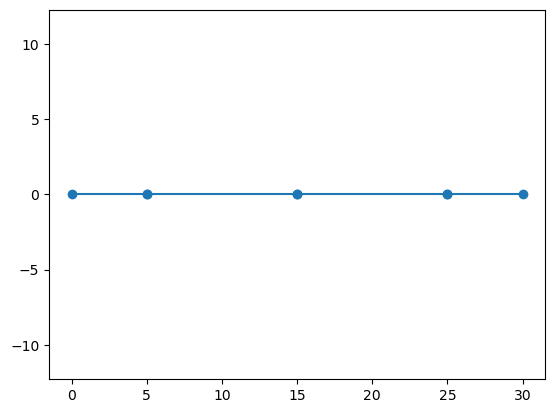

In [4]:
#Podstruktura A
L = 10
h_A = 0.4

ρ_A = 2700 # kg /m3
E_A = 70e9 # Pa
A_A = h_A*h_A # m^2
I_A = h_A*h_A**3/12 # m^4

vozlisca_A1 = np.array([[0,0],[L/2,0],[3*L/2,0],[5*L/2,0],[3*L,0]])
elementi_A1 = np.array ([[0,1],[1,2],[2,3],[3,4]])

[plt.plot(vozlisca_A1[e,0],vozlisca_A1[e,1],'-o',c='C0') for e in elementi_A1]
plt.axis('equal');

In [5]:
#A
n1=5
n2=10
vozlisca_AB=np.array([[x,0] for x in np.linspace(0,L/2,n1)])
vozlisca_BC=np.array([[x,0] for x in np.linspace(L/2,3*L/2,n2)])
vozlisca_CD=np.array([[x,0] for x in np.linspace(3*L/2,5*L/2,n2)])
vozlisca_DE=np.array([[x,0] for x in np.linspace(5*L/2,3*L,n1)])

In [6]:
#A
vozlisca_SK=np.vstack([vozlisca_AB,vozlisca_BC[1:],vozlisca_CD[1:],vozlisca_DE[1:]])
elementi_A = np.array([[i,i+1] for i in range(len(vozlisca_SK)-1)])

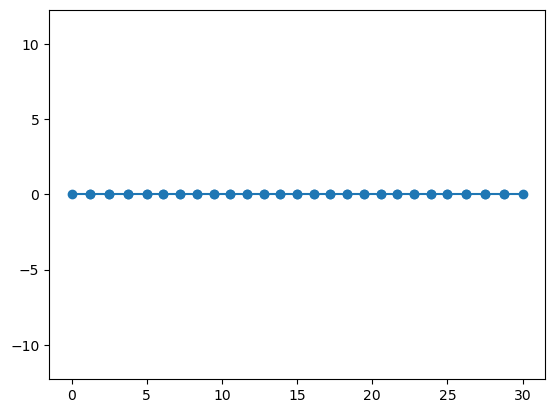

In [7]:
#A
[plt.plot(vozlisca_SK[e,0],vozlisca_SK[e,1],'-o',c='C0') for e in elementi_A]
plt.axis('equal');

In [8]:
#A
n_ps_A = 3*len(vozlisca_SK)
M_glob_A = np.zeros((n_ps_A,n_ps_A))
K_glob_A = np.zeros((n_ps_A,n_ps_A))

for element in elementi_A:
    Le = sp.spatial.distance.euclidean(vozlisca_SK[element[0]], vozlisca_SK[element[1]])
    αe = np.arctan2(np.diff(vozlisca_SK[element,1]) , np.diff(vozlisca_SK[element,0]))[0]
    ind = (3*element[:,None] + np.array([0, 1, 2])).flatten()
    
    M_glob_A[ind[:,None],ind] += M_o(A_A, Le, ρ_A, αe)
    K_glob_A[ind[:,None],ind] += K_o(A_A, E_A, I_A, Le, αe)

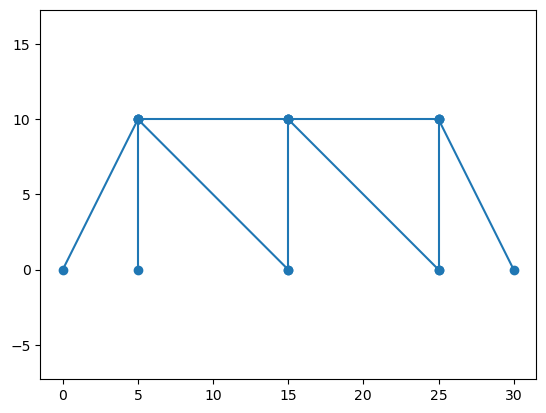

In [9]:
#paličje, podstruktura B
d= 0.2
E_B = 210e9 # Pa
A_B = np.pi * d**2 / 4 # m^2
ρ_B = 7800 # kg /m3

vozlisca_B = np.array([[0,0],[L/2,0],[3*L/2,0],[5*L/2,0],[3*L,0],[L/2,L],[3*L/2,L],[5*L/2,L]])
elementi_B = np.array([[0,5],[5,1],[5,2],[5,6],[6,2],[6,3],[6,7],[7,3],[7,4]])

[plt.plot(vozlisca_B[e,0],vozlisca_B[e,1],'-o',c='C0') for e in elementi_B]
plt.axis('equal');

In [10]:
#B
n_ps_B = 2*len(vozlisca_B)
M_glob_B = np.zeros((n_ps_B,n_ps_B))
K_glob_B = np.zeros((n_ps_B,n_ps_B))

for element in elementi_B:
    Le = sp.spatial.distance.euclidean(vozlisca_B[element[0]], vozlisca_B[element[1]])
    αe = np.arctan2(np.diff(vozlisca_B[element,1]) , np.diff(vozlisca_B[element,0]))[0]
    ind = (2*element[:,None] + np.array([0, 1])).flatten()
    
    M_glob_B[ind[:,None],ind] += M_p(A_B, Le, ρ_B)
    K_glob_B[ind[:,None],ind] += K_p(A_B, E_B, Le, αe)


In [59]:
n_ps_B, vozlisca_B.shape[0]

(16, 8)

In [11]:
#robni pogoji B
ind_vp_ps_B = np.array([0,1,5,9])

C_B_rp = np.zeros((len(ind_vp_ps_B),n_ps_B))
C_B_rp[np.arange(len(ind_vp_ps_B)),ind_vp_ps_B] = 1
C_B_rp.shape

(4, 16)

In [12]:
#robni pogoji A
ind_vp_ps_A = np.array([0,1,40,79])

C_A_rp = np.zeros((len(ind_vp_ps_A),n_ps_A))
C_A_rp[np.arange(len(ind_vp_ps_A)),ind_vp_ps_A] = 1


In [13]:
#Robni pogoji AB
C_rp = sp.linalg.block_diag(C_A_rp,C_B_rp)
C_rp.shape

(8, 97)

In [14]:
#povezava AB
C_A_pov = np.zeros((10,n_ps_A))
C_A_pov[[0,1],[0,1]] = 1
C_A_pov[[2,3],[12,13]] = 1
C_A_pov[[4,5],[39,40]] = 1
C_A_pov[[6,7],[66,67]] = 1
C_A_pov[[8,9],[78,79]] = 1

C_B_pov = np.zeros((10,n_ps_B))
C_B_pov[[0,1],[0,1]] = -1
C_B_pov[[2,3],[2,3]] = -1
C_B_pov[[4,5],[4,5]] = -1
C_B_pov[[6,7],[6,7]] = -1
C_B_pov[[8,9],[8,9]] = -1

C_pov = np.hstack([C_A_pov,C_B_pov]) 

In [15]:
C = np.vstack([C_rp, C_pov])
L_AB = sp.linalg.null_space(C)


In [16]:
M_glob_AB = L_AB.T @ sp.linalg.block_diag(M_glob_A, M_glob_B) @ L_AB 
K_glob_AB = L_AB.T @ sp.linalg.block_diag(K_glob_A, K_glob_B) @ L_AB


In [17]:
#MODALNA ANLIZA
# lastne vrednosti(val) in lastni vektorji(vec)
eig_val, eig_vec = sp.linalg.eig(K_glob_AB, M_glob_AB)

In [18]:
#urejanje po vrsti
_ind = np.argsort(np.abs(eig_val))
eig_val = np.abs(eig_val[_ind])
eig_vec = eig_vec[:,_ind]
eig_freq = np.abs(eig_val)**0.5 / 2 / np.pi

In [19]:
eig_vec_A = L_AB[:n_ps_A,:] @ eig_vec  
eig_vec_B = L_AB[-n_ps_B:,:] @ eig_vec

In [20]:
#frekvence
eig_freq[:5].round(1)

array([11.7, 17. , 21.9, 36.9, 37. ])

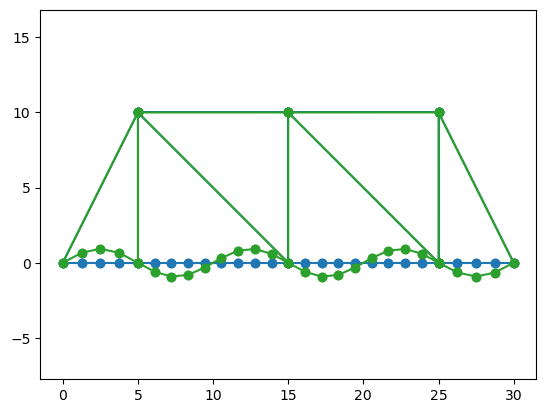

In [21]:
m = 3
s = 4 


pomiki_x_A = eig_vec_A[0::3,m].real
pomiki_y_A = eig_vec_A[1::3,m].real

# podstruktura B
pomiki_x_B = eig_vec_B[0::2,m].real
pomiki_y_B = eig_vec_B[1::2,m].real

# stacionarni izris
def_vozlisca_A = np.copy(vozlisca_SK)
def_vozlisca_A[:,0] += pomiki_x_A * s
def_vozlisca_A[:,1] += pomiki_y_A * s

def_vozlisca_B = np.copy(vozlisca_B)
def_vozlisca_B[:,0] += pomiki_x_B * s
def_vozlisca_B[:,1] += pomiki_y_B * s

# osnovno stanje
plt.axis('equal')
[plt.plot(*vozlisca_SK[e].T,'-o',c='C0') for e in elementi_A];
[plt.plot(*vozlisca_B[e].T,'-o',c='C0') for e in elementi_B];

# deformirano stanje
plt.axis('equal')
[plt.plot(*def_vozlisca_A[e].T,'-o',c='C2')for e in elementi_A];
[plt.plot(*def_vozlisca_B[e].T,'-o',c='C2')for e in elementi_B];

In [22]:
# masno normiranje
m_rr = np.diagonal(eig_vec.T @ M_glob_AB @ eig_vec)
Φ = eig_vec / m_rr**0.5

ω_r = eig_val**0.5

In [23]:
vozlisca=np.vstack([vozlisca_SK,vozlisca_B])
vozlisca.shape

(35, 2)

In [61]:
vozlisca_SK.shape[0]*3, vozlisca_B.shape[0]*2, vozlisca_SK.shape[0]*3 + vozlisca_B.shape[0]*2

(81, 16, 97)

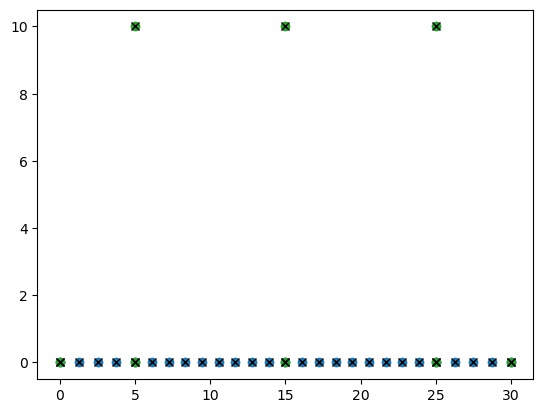

In [56]:
plt.plot(vozlisca_SK[:,0],vozlisca_SK[:,1],'o')
plt.plot(vozlisca_B[:,0],vozlisca_B[:,1],'o', c='C2')
plt.plot(vozlisca[:,0],vozlisca[:,1],'x', c='black')

In [25]:
# amplitudi vzbujevalnih sil
F1x = 300; 

f_glob = np.zeros(3*len(vozlisca_SK)+2*len(vozlisca_B)) # pazi na robne pogoje

# izbrana lokacija vzbujanja
tocka_B = np.array([L/2,L])
ind_vozlisca = np.where((vozlisca[:,None] == tocka_B).all(2).flatten())[0] #išče 
ind_x = 3*ind_vozlisca 
f_glob[ind_x] = F1x


f_glob = np.linalg.pinv(L_AB)@ f_glob # prehod v svet Q
h_r = Φ.T @ f_glob


In [46]:
f_glob.shape

(83,)

In [44]:
vozlisca.shape

(35, 2)

In [43]:
ind_vozlisca[0]

32

In [27]:
m_mod = np.diagonal(eig_vec.T @ M_glob_AB @ eig_vec) #modalne mase
Φ = eig_vec / m_mod**0.5

(Φ.T @ M_glob_AB @ Φ).round(1)

array([[ 1., -0., -0., ...,  0.,  0., -0.],
       [-0.,  1., -0., ...,  0., -0., -0.],
       [-0., -0.,  1., ..., -0.,  0.,  0.],
       ...,
       [ 0.,  0., -0., ...,  1., -0.,  0.],
       [ 0., -0.,  0., ..., -0.,  1.,  0.],
       [-0., -0.,  0., ...,  0.,  0.,  1.]])

In [28]:
M_m = Φ.T @ M_glob_AB @ Φ
K_m = Φ.T @ K_glob_AB @ Φ
h_m = Φ.T @ f_glob

In [62]:
M=len(eig_val)
δ = 0.003
ω = np.arange(1000)

H_mod = np.zeros([M,ω.shape[0]],dtype=complex)
phi_i = np.zeros([M,ω.shape[0]])

for i in range(M):
    ω_i = eig_val[i].real**0.5    
    H_mod[i] = h_m[i]/M_m[i,i]/(-ω**2+ω_i**2+2.j*δ*ω*ω_i)
    phi_i[i] = np.arctan2(2*δ*ω/ω_i, 1-(ω/ω_i)**2)
    
H_fiz = Φ @ H_mod

In [63]:
f_glob

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0., 300.])

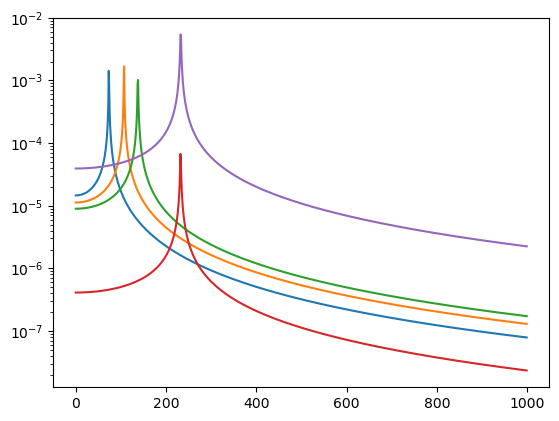

In [64]:
plt.semilogy(np.abs(H_mod[:5]).T);

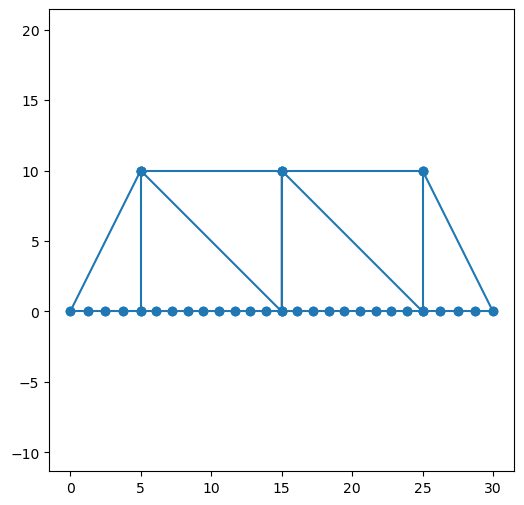

In [65]:
# osnovno stanje
fig,ax=plt.subplots(figsize=(6,6))
plt.axis('equal')
[ax.plot(*vozlisca_SK[e].T,'-o',c='C0') for e in elementi_A];
[ax.plot(*vozlisca_B[e].T,'-o',c='C0') for e in elementi_B];
ax.arrow(vozlisca[len(vozlisca_SK)+2][0],vozlisca[len(vozlisca_SK)+2][1], 0, 10 , head_width=0.05, head_length=0.1, fc='k', ec='k')
ax.plot(vozlisca[len(vozlisca_SK)+2][0],vozlisca[len(vozlisca_SK)+2][1],markersize = 20);

In [33]:
vozlisca[(len(vozlisca_SK)+5)][0]

5.0

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))


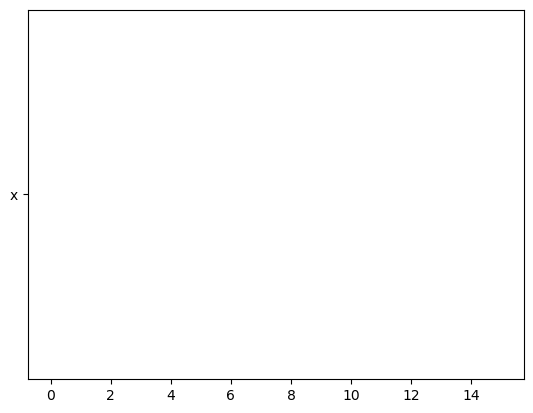

In [34]:
plt.plot(vozlisca[len(vozlisca_SK)+2][0],vozlisca[len(vozlisca_SK)+2][1],'C2','x')